In [ ]:
# 1. Import thư viện cần thiết
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN

Mounted at /content/drive


###Dự đoán giá vàng

In [ ]:
# 2. Đọc file csv và gắng index với giá Close
df_gold = pd.read_csv('/content/drive/MyDrive/DataSet/New Dataset(01 06 2024)/gold_price_2018_2024.csv')
df_gold['Date'] = pd.to_datetime(df_gold['Date'])
# df1=df.reset_index()['Close']

In [ ]:
df_gold

,Date,Value (USD per troy ounce)
0,2018-01-01,1307.018690
1,2018-01-02,1319.827953
2,2018-01-03,1311.501862
3,2018-01-04,1321.635371
4,2018-01-05,1319.589185
...,...,...
2339,2024-05-28,2353.805161
2340,2024-05-29,2357.459733
2341,2024-05-30,2335.806797
2342,2024-05-31,2346.815711


In [ ]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df_gold=scaler.fit_transform(np.array(df_gold['Value (USD per troy ounce)']).reshape(-1,1))

#Chia tỉ lệ 7:3

In [ ]:
# 4. Chia train test
train_size = int(0.7 * len(df_gold))
test_size = int(0.3 * len(df_gold))

train_data = df_gold[:train_size]
test_data = df_gold[train_size:train_size+test_size]

In [ ]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [ ]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [ ]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [ ]:
# 8. Define LSTM Model

model = Sequential()
model.add(SimpleRNN(50, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [ ]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,epochs=100,batch_size=64,verbose=1)

Epoch 1/100
25/25 [==============================] - 2s 17ms/step - loss: 0.0507
Epoch 2/100
25/25 [==============================] - 0s 17ms/step - loss: 0.0012
Epoch 3/100
25/25 [==============================] - 0s 16ms/step - loss: 9.5792e-04
Epoch 4/100
25/25 [==============================] - 1s 28ms/step - loss: 5.5646e-04
Epoch 5/100
25/25 [==============================] - 1s 31ms/step - loss: 5.4070e-04
Epoch 6/100
25/25 [==============================] - 1s 32ms/step - loss: 4.9109e-04
Epoch 7/100
25/25 [==============================] - 1s 30ms/step - loss: 4.9886e-04
Epoch 8/100
25/25 [==============================] - 1s 32ms/step - loss: 5.3725e-04
Epoch 9/100
25/25 [==============================] - 1s 33ms/step - loss: 4.1229e-04
Epoch 10/100
25/25 [==============================] - 1s 33ms/step - loss: 3.6254e-04
Epoch 11/100
25/25 [==============================] - 0s 16ms/step - loss: 3.7981e-04
Epoch 12/100
25/25 [==============================] - 0s 17ms/step - lo

In [ ]:
# 10. Dự báo dữ liệu test
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

19/19 [==============================] - 0s 5ms/step


In [ ]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)


In [ ]:
#12 Đánh giá độ chính xác thuật toán
test_rmse = np.sqrt(np.mean((y_pred - ytest) ** 2))

test_mae = np.mean(np.abs(y_pred - ytest))

test_mape = np.mean(np.abs((ytest - y_pred) / ytest)) * 100

print('Testing RMSE:', test_rmse)

print('Testing MAE:', test_mae)

print('Testing MAPE:', test_mape)



Testing RMSE: 1965.2490561448521
Testing MAE: 1959.069157592933
Testing MAPE: 322868.5269734294


In [ ]:
# 13. Dự báo 30 ngày tiếp theo

x_input=test_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

lst_output = []
n_steps = 100
i = 0
while i < 30:
    if len(temp_input) > n_steps:
        x_input = np.array(temp_input[-n_steps:])
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = np.array(temp_input).reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i += 1

# Dự đoán 60 ngày tiếp theo
lst_output_60 = []
temp_input = temp_input[:]

for i in range(30):
    if len(temp_input) > n_steps:
        x_input = np.array(temp_input[-n_steps:])
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output_60.extend(yhat.tolist())
    else:
        x_input = np.array(temp_input).reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output_60.extend(yhat.tolist())

# Dự đoán 90 ngày tiếp theo
lst_output_90 = []
temp_input = temp_input[:]

for i in range(30):
    if len(temp_input) > n_steps:
        x_input = np.array(temp_input[-n_steps:])
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output_90.extend(yhat.tolist())
    else:
        x_input = np.array(temp_input).reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output_90.extend(yhat.tolist())

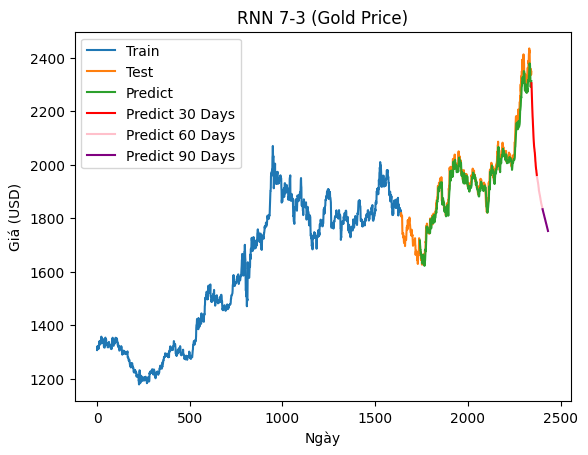

In [ ]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))

# Vẽ dữ liệu dự đoán 30 ngày tiếp theo
future_predict_index = pd.RangeIndex(start=train_size + test_size, stop=train_size + test_size + 30, step=1)
plt.plot(future_predict_index, scaler.inverse_transform(lst_output), color='red')

# Vẽ dữ liệu dự đoán 60 ngày tiếp theo
future_predict_index_60 = pd.RangeIndex(start=train_size + test_size + 30, stop=train_size + test_size + 60, step=1)
plt.plot(future_predict_index_60, scaler.inverse_transform(lst_output_60), color='pink')

# Vẽ dữ liệu dự đoán 90 ngày tiếp theo
future_predict_index_90 = pd.RangeIndex(start=train_size + test_size + 60, stop=train_size + test_size + 90, step=1)
plt.plot(future_predict_index_90, scaler.inverse_transform(lst_output_90), color='purple')
plt.legend(['Train','Test','Predict', 'Predict 30 Days', 'Predict 60 Days', 'Predict 90 Days'])
plt.title('RNN 7-3 (Gold Price)')
plt.xlabel('Ngày')
plt.ylabel('Giá (USD)')
plt.show()



#Chia tỉ lệ 8:2

Epoch 1/100
28/28 [==============================] - 2s 20ms/step - loss: 0.0034
Epoch 2/100
28/28 [==============================] - 1s 18ms/step - loss: 4.2345e-04
Epoch 3/100
28/28 [==============================] - 1s 20ms/step - loss: 4.2144e-04
Epoch 4/100
28/28 [==============================] - 1s 19ms/step - loss: 3.9383e-04
Epoch 5/100
28/28 [==============================] - 1s 20ms/step - loss: 3.6008e-04
Epoch 6/100
28/28 [==============================] - 1s 19ms/step - loss: 3.7425e-04
Epoch 7/100
28/28 [==============================] - 1s 18ms/step - loss: 3.3490e-04
Epoch 8/100
28/28 [==============================] - 0s 17ms/step - loss: 3.0987e-04
Epoch 9/100
28/28 [==============================] - 1s 19ms/step - loss: 3.2025e-04
Epoch 10/100
28/28 [==============================] - 1s 18ms/step - loss: 2.9376e-04
Epoch 11/100
28/28 [==============================] - 0s 17ms/step - loss: 3.0413e-04
Epoch 12/100
28/28 [==============================] - 0s 16ms/step 

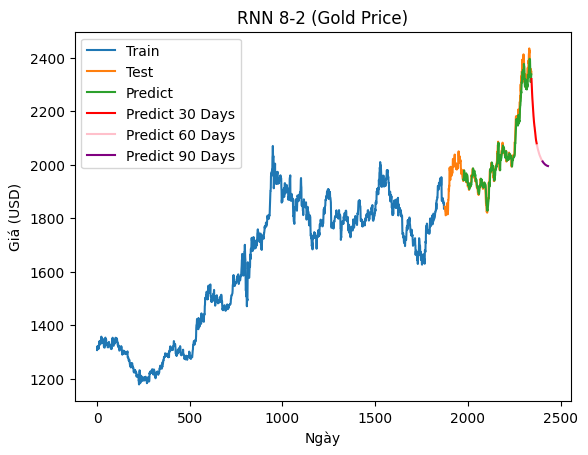

In [ ]:
# 4. Chia train test
train_size = int(0.8 * len(df_gold))
test_size = int(0.2 * len(df_gold))

train_data = df_gold[:train_size]
test_data = df_gold[train_size:train_size+test_size]

# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

# 8. Define LSTM Model

model = Sequential()
model.add(SimpleRNN(50, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,epochs=100,batch_size=64,verbose=1)

# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)

#12 Đánh giá độ chính xác thuật toán
test_rmse = np.sqrt(np.mean((y_pred - ytest) ** 2))
test_mae = np.mean(np.abs(y_pred - ytest))
test_mape = np.mean(np.abs((ytest - y_pred) / ytest)) * 100

print('Testing RMSE:', test_rmse)
print('Testing MAE:', test_mae)
print('Testing MAPE:', test_mape)

# 13. Dự báo 30 ngày tiếp theo

x_input=test_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

lst_output = []
n_steps = 100
i = 0
while i < 30:
    if len(temp_input) > n_steps:
        x_input = np.array(temp_input[-n_steps:])
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = np.array(temp_input).reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i += 1

# Dự đoán 60 ngày tiếp theo
lst_output_60 = []
temp_input = temp_input[:]

for i in range(30):
    if len(temp_input) > n_steps:
        x_input = np.array(temp_input[-n_steps:])
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output_60.extend(yhat.tolist())
    else:
        x_input = np.array(temp_input).reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output_60.extend(yhat.tolist())

# Dự đoán 90 ngày tiếp theo
lst_output_90 = []
temp_input = temp_input[:]

for i in range(30):
    if len(temp_input) > n_steps:
        x_input = np.array(temp_input[-n_steps:])
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output_90.extend(yhat.tolist())
    else:
        x_input = np.array(temp_input).reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output_90.extend(yhat.tolist())


# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))

# Vẽ dữ liệu dự đoán 30 ngày tiếp theo
future_predict_index = pd.RangeIndex(start=train_size + test_size, stop=train_size + test_size + 30, step=1)
plt.plot(future_predict_index, scaler.inverse_transform(lst_output), color='red')

# Vẽ dữ liệu dự đoán 60 ngày tiếp theo
future_predict_index_60 = pd.RangeIndex(start=train_size + test_size + 30, stop=train_size + test_size + 60, step=1)
plt.plot(future_predict_index_60, scaler.inverse_transform(lst_output_60), color='pink')

# Vẽ dữ liệu dự đoán 90 ngày tiếp theo
future_predict_index_90 = pd.RangeIndex(start=train_size + test_size + 60, stop=train_size + test_size + 90, step=1)
plt.plot(future_predict_index_90, scaler.inverse_transform(lst_output_90), color='purple')
plt.legend(['Train','Test','Predict', 'Predict 30 Days', 'Predict 60 Days', 'Predict 90 Days'])
plt.title('RNN 8-2 (Gold Price)')
plt.xlabel('Ngày')
plt.ylabel('Giá (USD)')
plt.show()


#Chia tỉ lệ 9:1

In [ ]:
# 4. Chia train test
train_size = int(0.9 * len(df_gold))
test_size = int(0.1 * len(df_gold))

train_data = df_gold[:train_size]
test_data = df_gold[train_size:train_size+test_size]

# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

# 8. Define LSTM Model

model = Sequential()
model.add(SimpleRNN(50, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,epochs=100,batch_size=64,verbose=1)

# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)

#12 Đánh giá độ chính xác thuật toán
test_rmse = np.sqrt(np.mean((y_pred - ytest) ** 2))
test_mae = np.mean(np.abs(y_pred - ytest))
test_mape = np.mean(np.abs((ytest - y_pred) / ytest)) * 100

print('Testing RMSE:', test_rmse)
print('Testing MAE:', test_mae)
print('Testing MAPE:', test_mape)

# 13. Dự báo 30 ngày tiếp theo

x_input=test_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

lst_output = []
n_steps = 100
i = 0
while i < 30:
    if len(temp_input) > n_steps:
        x_input = np.array(temp_input[-n_steps:])
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = np.array(temp_input).reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i += 1

# Dự đoán 60 ngày tiếp theo
lst_output_60 = []
temp_input = temp_input[:]

for i in range(30):
    if len(temp_input) > n_steps:
        x_input = np.array(temp_input[-n_steps:])
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output_60.extend(yhat.tolist())
    else:
        x_input = np.array(temp_input).reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output_60.extend(yhat.tolist())

# Dự đoán 90 ngày tiếp theo
lst_output_90 = []
temp_input = temp_input[:]

for i in range(30):
    if len(temp_input) > n_steps:
        x_input = np.array(temp_input[-n_steps:])
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output_90.extend(yhat.tolist())
    else:
        x_input = np.array(temp_input).reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output_90.extend(yhat.tolist())



Epoch 1/100
32/32 [==============================] - 2s 17ms/step - loss: 0.0102
Epoch 2/100
32/32 [==============================] - 1s 17ms/step - loss: 5.0306e-04
Epoch 3/100
32/32 [==============================] - 1s 16ms/step - loss: 4.3414e-04
Epoch 4/100
32/32 [==============================] - 1s 18ms/step - loss: 4.0427e-04
Epoch 5/100
32/32 [==============================] - 1s 19ms/step - loss: 3.8416e-04
Epoch 6/100
32/32 [==============================] - 1s 18ms/step - loss: 3.3616e-04
Epoch 7/100
32/32 [==============================] - 1s 39ms/step - loss: 3.2375e-04
Epoch 8/100
32/32 [==============================] - 1s 18ms/step - loss: 3.0578e-04
Epoch 9/100
32/32 [==============================] - 1s 17ms/step - loss: 3.0159e-04
Epoch 10/100
32/32 [==============================] - 1s 18ms/step - loss: 2.8324e-04
Epoch 11/100
32/32 [==============================] - 1s 30ms/step - loss: 2.7239e-04
Epoch 12/100
32/32 [==============================] - 1s 33ms/step 

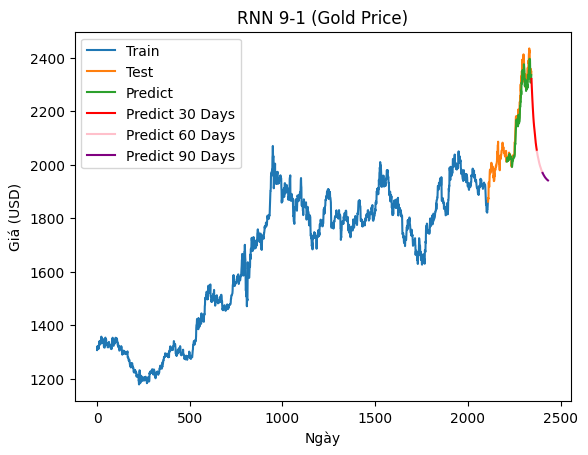

In [ ]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))

# Vẽ dữ liệu dự đoán 30 ngày tiếp theo
future_predict_index = pd.RangeIndex(start=train_size + test_size, stop=train_size + test_size + 30, step=1)
plt.plot(future_predict_index, scaler.inverse_transform(lst_output), color='red')

# Vẽ dữ liệu dự đoán 60 ngày tiếp theo
future_predict_index_60 = pd.RangeIndex(start=train_size + test_size + 30, stop=train_size + test_size + 60, step=1)
plt.plot(future_predict_index_60, scaler.inverse_transform(lst_output_60), color='pink')

# Vẽ dữ liệu dự đoán 90 ngày tiếp theo
future_predict_index_90 = pd.RangeIndex(start=train_size + test_size + 60, stop=train_size + test_size + 90, step=1)
plt.plot(future_predict_index_90, scaler.inverse_transform(lst_output_90), color='purple')
plt.legend(['Train','Test','Predict', 'Predict 30 Days', 'Predict 60 Days', 'Predict 90 Days'])
plt.title('RNN 9-1 (Gold Price)')
plt.xlabel('Ngày')
plt.ylabel('Giá (USD)')
plt.show()



#Dự đoán giá bạc

In [ ]:
# 2. Đọc file csv và gắng index với giá Close
df_silver = pd.read_csv('/content/drive/MyDrive/DataSet/New Dataset(01 06 2024)/silver_price_2018_2024.csv')
df_silver['Date'] = pd.to_datetime(df_silver['Date'])
# df1=df.reset_index()['Close']

In [ ]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df_silver=scaler.fit_transform(np.array(df_silver['Value (USD per troy ounce)']).reshape(-1,1))

#Chia tỉ lệ 7:3


In [ ]:
# 4. Chia train test
train_size = int(0.7 * len(df_silver))
test_size = int(0.3 * len(df_silver))

train_data = df_silver[:train_size]
test_data = df_silver[train_size:train_size+test_size]

# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

# 8. Define LSTM Model

model = Sequential()
model.add(SimpleRNN(50, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,epochs=100,batch_size=64,verbose=1)

# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)

#12 Đánh giá độ chính xác thuật toán
test_rmse = np.sqrt(np.mean((y_pred - ytest) ** 2))
test_mae = np.mean(np.abs(y_pred - ytest))
test_mape = np.mean(np.abs((ytest - y_pred) / ytest)) * 100

print('Testing RMSE:', test_rmse)
print('Testing MAE:', test_mae)
print('Testing MAPE:', test_mape)

# 13. Dự báo 30 ngày tiếp theo

x_input=test_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

lst_output = []
n_steps = 100
i = 0
while i < 30:
    if len(temp_input) > n_steps:
        x_input = np.array(temp_input[-n_steps:])
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = np.array(temp_input).reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i += 1

# Dự đoán 60 ngày tiếp theo
lst_output_60 = []
temp_input = temp_input[:]

for i in range(30):
    if len(temp_input) > n_steps:
        x_input = np.array(temp_input[-n_steps:])
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output_60.extend(yhat.tolist())
    else:
        x_input = np.array(temp_input).reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output_60.extend(yhat.tolist())

# Dự đoán 90 ngày tiếp theo
lst_output_90 = []
temp_input = temp_input[:]

for i in range(30):
    if len(temp_input) > n_steps:
        x_input = np.array(temp_input[-n_steps:])
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output_90.extend(yhat.tolist())
    else:
        x_input = np.array(temp_input).reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output_90.extend(yhat.tolist())

Epoch 1/100
25/25 [==============================] - 2s 16ms/step - loss: 0.0029
Epoch 2/100
25/25 [==============================] - 0s 17ms/step - loss: 8.8567e-04
Epoch 3/100
25/25 [==============================] - 0s 20ms/step - loss: 7.7511e-04
Epoch 4/100
25/25 [==============================] - 1s 27ms/step - loss: 7.2518e-04
Epoch 5/100
25/25 [==============================] - 1s 30ms/step - loss: 6.6752e-04
Epoch 6/100
25/25 [==============================] - 1s 32ms/step - loss: 6.1974e-04
Epoch 7/100
25/25 [==============================] - 1s 31ms/step - loss: 5.6131e-04
Epoch 8/100
25/25 [==============================] - 1s 32ms/step - loss: 6.6316e-04
Epoch 9/100
25/25 [==============================] - 1s 34ms/step - loss: 5.1309e-04
Epoch 10/100
25/25 [==============================] - 1s 31ms/step - loss: 6.0828e-04
Epoch 11/100
25/25 [==============================] - 1s 22ms/step - loss: 5.3937e-04
Epoch 12/100
25/25 [==============================] - 0s 17ms/step 

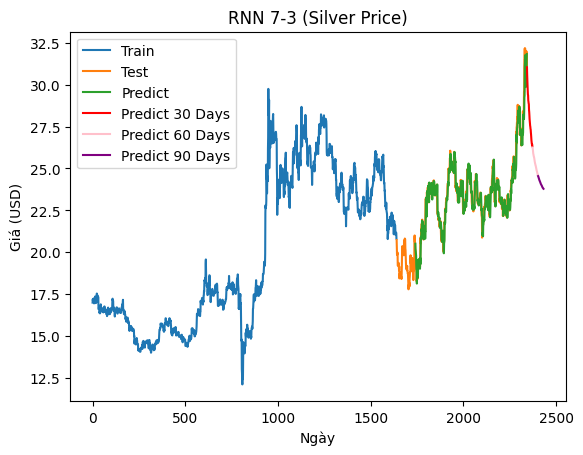

In [ ]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))

# Vẽ dữ liệu dự đoán 30 ngày tiếp theo
future_predict_index = pd.RangeIndex(start=train_size + test_size, stop=train_size + test_size + 30, step=1)
plt.plot(future_predict_index, scaler.inverse_transform(lst_output), color='red')

# Vẽ dữ liệu dự đoán 60 ngày tiếp theo
future_predict_index_60 = pd.RangeIndex(start=train_size + test_size + 30, stop=train_size + test_size + 60, step=1)
plt.plot(future_predict_index_60, scaler.inverse_transform(lst_output_60), color='pink')

# Vẽ dữ liệu dự đoán 90 ngày tiếp theo
future_predict_index_90 = pd.RangeIndex(start=train_size + test_size + 60, stop=train_size + test_size + 90, step=1)
plt.plot(future_predict_index_90, scaler.inverse_transform(lst_output_90), color='purple')
plt.legend(['Train','Test','Predict', 'Predict 30 Days', 'Predict 60 Days', 'Predict 90 Days'])
plt.title('RNN 7-3 (Silver Price)')
plt.xlabel('Ngày')
plt.ylabel('Giá (USD)')
plt.show()



#Chia tỉ lệ 8:2

In [ ]:
# 4. Chia train test
train_size = int(0.8 * len(df_silver))
test_size = int(0.2 * len(df_silver))

train_data = df_silver[:train_size]
test_data = df_silver[train_size:train_size+test_size]

# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

# 8. Define LSTM Model

model = Sequential()
model.add(SimpleRNN(50, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,epochs=100,batch_size=64,verbose=1)

# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)

#12 Đánh giá độ chính xác thuật toán
test_rmse = np.sqrt(np.mean((y_pred - ytest) ** 2))
test_mae = np.mean(np.abs(y_pred - ytest))
test_mape = np.mean(np.abs((ytest - y_pred) / ytest)) * 100

print('Testing RMSE:', test_rmse)
print('Testing MAE:', test_mae)
print('Testing MAPE:', test_mape)

# 13. Dự báo 30 ngày tiếp theo

x_input=test_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

lst_output = []
n_steps = 100
i = 0
while i < 30:
    if len(temp_input) > n_steps:
        x_input = np.array(temp_input[-n_steps:])
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = np.array(temp_input).reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i += 1

# Dự đoán 60 ngày tiếp theo
lst_output_60 = []
temp_input = temp_input[:]

for i in range(30):
    if len(temp_input) > n_steps:
        x_input = np.array(temp_input[-n_steps:])
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output_60.extend(yhat.tolist())
    else:
        x_input = np.array(temp_input).reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output_60.extend(yhat.tolist())

# Dự đoán 90 ngày tiếp theo
lst_output_90 = []
temp_input = temp_input[:]

for i in range(30):
    if len(temp_input) > n_steps:
        x_input = np.array(temp_input[-n_steps:])
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output_90.extend(yhat.tolist())
    else:
        x_input = np.array(temp_input).reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output_90.extend(yhat.tolist())



Epoch 1/100
28/28 [==============================] - 3s 33ms/step - loss: 0.0173
Epoch 2/100
28/28 [==============================] - 1s 34ms/step - loss: 0.0015
Epoch 3/100
28/28 [==============================] - 1s 34ms/step - loss: 0.0013
Epoch 4/100
28/28 [==============================] - 1s 18ms/step - loss: 0.0011
Epoch 5/100
28/28 [==============================] - 0s 16ms/step - loss: 9.4528e-04
Epoch 6/100
28/28 [==============================] - 0s 18ms/step - loss: 8.6441e-04
Epoch 7/100
28/28 [==============================] - 1s 19ms/step - loss: 8.1022e-04
Epoch 8/100
28/28 [==============================] - 1s 20ms/step - loss: 7.3688e-04
Epoch 9/100
28/28 [==============================] - 1s 18ms/step - loss: 7.1963e-04
Epoch 10/100
28/28 [==============================] - 1s 19ms/step - loss: 6.3497e-04
Epoch 11/100
28/28 [==============================] - 0s 17ms/step - loss: 6.2921e-04
Epoch 12/100
28/28 [==============================] - 0s 17ms/step - loss: 5.98

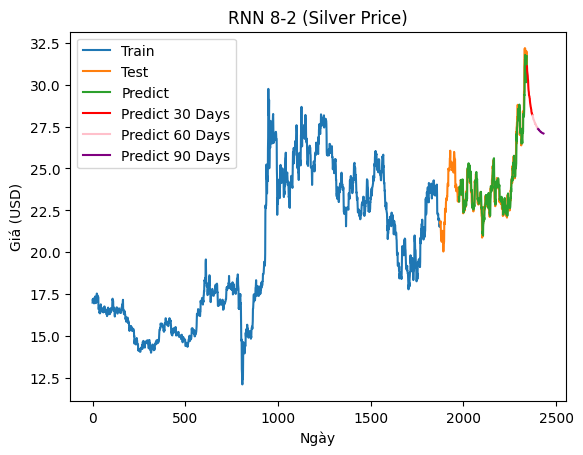

In [ ]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))

# Vẽ dữ liệu dự đoán 30 ngày tiếp theo
future_predict_index = pd.RangeIndex(start=train_size + test_size, stop=train_size + test_size + 30, step=1)
plt.plot(future_predict_index, scaler.inverse_transform(lst_output), color='red')

# Vẽ dữ liệu dự đoán 60 ngày tiếp theo
future_predict_index_60 = pd.RangeIndex(start=train_size + test_size + 30, stop=train_size + test_size + 60, step=1)
plt.plot(future_predict_index_60, scaler.inverse_transform(lst_output_60), color='pink')

# Vẽ dữ liệu dự đoán 90 ngày tiếp theo
future_predict_index_90 = pd.RangeIndex(start=train_size + test_size + 60, stop=train_size + test_size + 90, step=1)
plt.plot(future_predict_index_90, scaler.inverse_transform(lst_output_90), color='purple')
plt.legend(['Train','Test','Predict', 'Predict 30 Days', 'Predict 60 Days', 'Predict 90 Days'])
plt.title('RNN 8-2 (Silver Price)')
plt.xlabel('Ngày')
plt.ylabel('Giá (USD)')
plt.show()

#Chia tỉ lệ 9:1

In [ ]:
# 4. Chia train test
train_size = int(0.9 * len(df_silver))
test_size = int(0.1 * len(df_silver))

train_data = df_silver[:train_size]
test_data = df_silver[train_size:train_size+test_size]

# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

# 8. Define LSTM Model

model = Sequential()
model.add(SimpleRNN(50, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,epochs=100,batch_size=64,verbose=1)

# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)

#12 Đánh giá độ chính xác thuật toán
test_rmse = np.sqrt(np.mean((y_pred - ytest) ** 2))
test_mae = np.mean(np.abs(y_pred - ytest))
test_mape = np.mean(np.abs((ytest - y_pred) / ytest)) * 100

print('Testing RMSE:', test_rmse)
print('Testing MAE:', test_mae)
print('Testing MAPE:', test_mape)

# 13. Dự báo 30 ngày tiếp theo

x_input=test_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

lst_output = []
n_steps = 100
i = 0
while i < 30:
    if len(temp_input) > n_steps:
        x_input = np.array(temp_input[-n_steps:])
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = np.array(temp_input).reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i += 1

# Dự đoán 60 ngày tiếp theo
lst_output_60 = []
temp_input = temp_input[:]

for i in range(30):
    if len(temp_input) > n_steps:
        x_input = np.array(temp_input[-n_steps:])
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output_60.extend(yhat.tolist())
    else:
        x_input = np.array(temp_input).reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output_60.extend(yhat.tolist())

# Dự đoán 90 ngày tiếp theo
lst_output_90 = []
temp_input = temp_input[:]

for i in range(30):
    if len(temp_input) > n_steps:
        x_input = np.array(temp_input[-n_steps:])
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output_90.extend(yhat.tolist())
    else:
        x_input = np.array(temp_input).reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output_90.extend(yhat.tolist())


Epoch 1/100
32/32 [==============================] - 2s 18ms/step - loss: 0.0072
Epoch 2/100
32/32 [==============================] - 1s 19ms/step - loss: 0.0011
Epoch 3/100
32/32 [==============================] - 1s 18ms/step - loss: 7.6042e-04
Epoch 4/100
32/32 [==============================] - 1s 18ms/step - loss: 6.8457e-04
Epoch 5/100
32/32 [==============================] - 1s 17ms/step - loss: 6.5229e-04
Epoch 6/100
32/32 [==============================] - 1s 19ms/step - loss: 5.8574e-04
Epoch 7/100
32/32 [==============================] - 1s 19ms/step - loss: 5.6119e-04
Epoch 8/100
32/32 [==============================] - 1s 16ms/step - loss: 5.4604e-04
Epoch 9/100
32/32 [==============================] - 1s 19ms/step - loss: 5.0764e-04
Epoch 10/100
32/32 [==============================] - 1s 19ms/step - loss: 5.3070e-04
Epoch 11/100
32/32 [==============================] - 1s 17ms/step - loss: 5.0529e-04
Epoch 12/100
32/32 [==============================] - 1s 17ms/step - lo

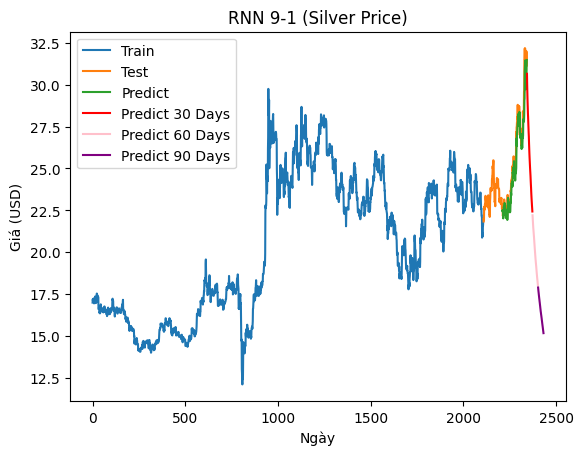

In [ ]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))

# Vẽ dữ liệu dự đoán 30 ngày tiếp theo
future_predict_index = pd.RangeIndex(start=train_size + test_size, stop=train_size + test_size + 30, step=1)
plt.plot(future_predict_index, scaler.inverse_transform(lst_output), color='red')

# Vẽ dữ liệu dự đoán 60 ngày tiếp theo
future_predict_index_60 = pd.RangeIndex(start=train_size + test_size + 30, stop=train_size + test_size + 60, step=1)
plt.plot(future_predict_index_60, scaler.inverse_transform(lst_output_60), color='pink')

# Vẽ dữ liệu dự đoán 90 ngày tiếp theo
future_predict_index_90 = pd.RangeIndex(start=train_size + test_size + 60, stop=train_size + test_size + 90, step=1)
plt.plot(future_predict_index_90, scaler.inverse_transform(lst_output_90), color='purple')
plt.legend(['Train','Test','Predict', 'Predict 30 Days', 'Predict 60 Days', 'Predict 90 Days'])
plt.title('RNN 9-1 (Silver Price)')
plt.xlabel('Ngày')
plt.ylabel('Giá (USD)')
plt.show()

##Dự đoán giá Platinum


In [ ]:
# 2. Đọc file csv và gắng index với giá Close
df_platium = pd.read_csv('/content/drive/MyDrive/DataSet/New Dataset(01 06 2024)/platium_price_2018_2024.csv')
df_platium['Date'] = pd.to_datetime(df_platium['Date'])
# df1=df.reset_index()['Close']

In [ ]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df_platium=scaler.fit_transform(np.array(df_platium['Value (USD per troy ounce)']).reshape(-1,1))

#Chia tỉ lệ 7:3

In [ ]:
# 4. Chia train test
train_size = int(0.7 * len(df_platium))
test_size = int(0.3 * len(df_platium))

train_data = df_platium[:train_size]
test_data = df_platium[train_size:train_size+test_size]

# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

# 8. Define LSTM Model

model = Sequential()
model.add(SimpleRNN(50, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,epochs=100,batch_size=64,verbose=1)

# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)

#12 Đánh giá độ chính xác thuật toán
test_rmse = np.sqrt(np.mean((y_pred - ytest) ** 2))
test_mae = np.mean(np.abs(y_pred - ytest))
test_mape = np.mean(np.abs((ytest - y_pred) / ytest)) * 100

print('Testing RMSE:', test_rmse)
print('Testing MAE:', test_mae)
print('Testing MAPE:', test_mape)

# 13. Dự báo 30 ngày tiếp theo

x_input=test_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

lst_output = []
n_steps = 100
i = 0
while i < 30:
    if len(temp_input) > n_steps:
        x_input = np.array(temp_input[-n_steps:])
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = np.array(temp_input).reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i += 1

# Dự đoán 60 ngày tiếp theo
lst_output_60 = []
temp_input = temp_input[:]

for i in range(30):
    if len(temp_input) > n_steps:
        x_input = np.array(temp_input[-n_steps:])
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output_60.extend(yhat.tolist())
    else:
        x_input = np.array(temp_input).reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output_60.extend(yhat.tolist())

# Dự đoán 90 ngày tiếp theo
lst_output_90 = []
temp_input = temp_input[:]

for i in range(30):
    if len(temp_input) > n_steps:
        x_input = np.array(temp_input[-n_steps:])
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output_90.extend(yhat.tolist())
    else:
        x_input = np.array(temp_input).reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output_90.extend(yhat.tolist())



Epoch 1/100
25/25 [==============================] - 1s 18ms/step - loss: 0.0384
Epoch 2/100
25/25 [==============================] - 0s 19ms/step - loss: 0.0049
Epoch 3/100
25/25 [==============================] - 0s 17ms/step - loss: 0.0036
Epoch 4/100
25/25 [==============================] - 0s 17ms/step - loss: 0.0031
Epoch 5/100
25/25 [==============================] - 0s 16ms/step - loss: 0.0027
Epoch 6/100
25/25 [==============================] - 0s 17ms/step - loss: 0.0025
Epoch 7/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0021
Epoch 8/100
25/25 [==============================] - 1s 31ms/step - loss: 0.0022
Epoch 9/100
25/25 [==============================] - 1s 31ms/step - loss: 0.0026
Epoch 10/100
25/25 [==============================] - 1s 30ms/step - loss: 0.0017
Epoch 11/100
25/25 [==============================] - 1s 30ms/step - loss: 0.0016
Epoch 12/100
25/25 [==============================] - 1s 31ms/step - loss: 0.0016
Epoch 13/100
25/25 [=====

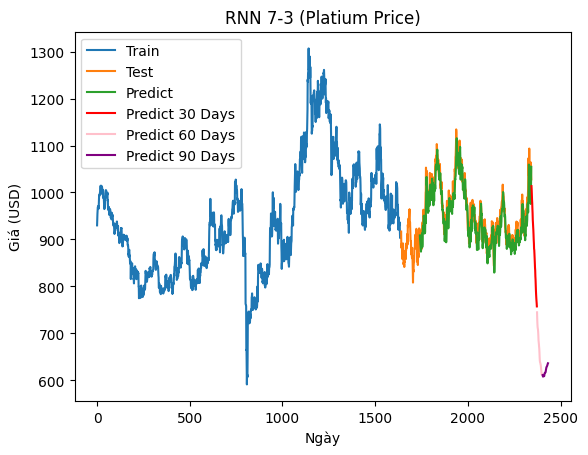

In [ ]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))

# Vẽ dữ liệu dự đoán 30 ngày tiếp theo
future_predict_index = pd.RangeIndex(start=train_size + test_size, stop=train_size + test_size + 30, step=1)
plt.plot(future_predict_index, scaler.inverse_transform(lst_output), color='red')

# Vẽ dữ liệu dự đoán 60 ngày tiếp theo
future_predict_index_60 = pd.RangeIndex(start=train_size + test_size + 30, stop=train_size + test_size + 60, step=1)
plt.plot(future_predict_index_60, scaler.inverse_transform(lst_output_60), color='pink')

# Vẽ dữ liệu dự đoán 90 ngày tiếp theo
future_predict_index_90 = pd.RangeIndex(start=train_size + test_size + 60, stop=train_size + test_size + 90, step=1)
plt.plot(future_predict_index_90, scaler.inverse_transform(lst_output_90), color='purple')
plt.legend(['Train','Test','Predict', 'Predict 30 Days', 'Predict 60 Days', 'Predict 90 Days'])
plt.title('RNN 7-3 (Platium Price)')
plt.xlabel('Ngày')
plt.ylabel('Giá (USD)')
plt.show()

#Chia tỉ lệ 8:2

In [ ]:
# 4. Chia train test
train_size = int(0.8 * len(df_platium))
test_size = int(0.2 * len(df_platium))

train_data = df_platium[:train_size]
test_data = df_platium[train_size:train_size+test_size]

# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

# 8. Define LSTM Model

model = Sequential()
model.add(SimpleRNN(50, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,epochs=100,batch_size=64,verbose=1)

# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)

#12 Đánh giá độ chính xác thuật toán
test_rmse = np.sqrt(np.mean((y_pred - ytest) ** 2))
test_mae = np.mean(np.abs(y_pred - ytest))
test_mape = np.mean(np.abs((ytest - y_pred) / ytest)) * 100

print('Testing RMSE:', test_rmse)
print('Testing MAE:', test_mae)
print('Testing MAPE:', test_mape)

# 13. Dự báo 30 ngày tiếp theo

x_input=test_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

lst_output = []
n_steps = 100
i = 0
while i < 30:
    if len(temp_input) > n_steps:
        x_input = np.array(temp_input[-n_steps:])
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = np.array(temp_input).reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i += 1

# Dự đoán 60 ngày tiếp theo
lst_output_60 = []
temp_input = temp_input[:]

for i in range(30):
    if len(temp_input) > n_steps:
        x_input = np.array(temp_input[-n_steps:])
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output_60.extend(yhat.tolist())
    else:
        x_input = np.array(temp_input).reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output_60.extend(yhat.tolist())

# Dự đoán 90 ngày tiếp theo
lst_output_90 = []
temp_input = temp_input[:]

for i in range(30):
    if len(temp_input) > n_steps:
        x_input = np.array(temp_input[-n_steps:])
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output_90.extend(yhat.tolist())
    else:
        x_input = np.array(temp_input).reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output_90.extend(yhat.tolist())

Epoch 1/100
28/28 [==============================] - 2s 32ms/step - loss: 0.0063
Epoch 2/100
28/28 [==============================] - 1s 33ms/step - loss: 0.0014
Epoch 3/100
28/28 [==============================] - 1s 32ms/step - loss: 0.0011
Epoch 4/100
28/28 [==============================] - 1s 33ms/step - loss: 0.0010
Epoch 5/100
28/28 [==============================] - 1s 31ms/step - loss: 9.1982e-04
Epoch 6/100
28/28 [==============================] - 1s 27ms/step - loss: 8.6715e-04
Epoch 7/100
28/28 [==============================] - 1s 18ms/step - loss: 8.4878e-04
Epoch 8/100
28/28 [==============================] - 1s 19ms/step - loss: 8.6644e-04
Epoch 9/100
28/28 [==============================] - 1s 18ms/step - loss: 8.4316e-04
Epoch 10/100
28/28 [==============================] - 1s 18ms/step - loss: 7.7362e-04
Epoch 11/100
28/28 [==============================] - 1s 18ms/step - loss: 7.5233e-04
Epoch 12/100
28/28 [==============================] - 1s 19ms/step - loss: 7.39

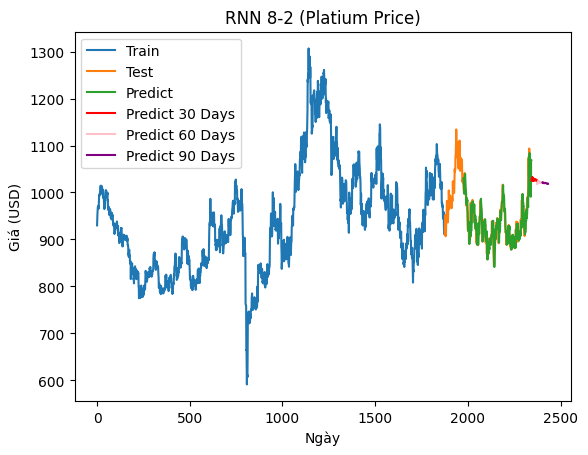

In [ ]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))

# Vẽ dữ liệu dự đoán 30 ngày tiếp theo
future_predict_index = pd.RangeIndex(start=train_size + test_size, stop=train_size + test_size + 30, step=1)
plt.plot(future_predict_index, scaler.inverse_transform(lst_output), color='red')

# Vẽ dữ liệu dự đoán 60 ngày tiếp theo
future_predict_index_60 = pd.RangeIndex(start=train_size + test_size + 30, stop=train_size + test_size + 60, step=1)
plt.plot(future_predict_index_60, scaler.inverse_transform(lst_output_60), color='pink')

# Vẽ dữ liệu dự đoán 90 ngày tiếp theo
future_predict_index_90 = pd.RangeIndex(start=train_size + test_size + 60, stop=train_size + test_size + 90, step=1)
plt.plot(future_predict_index_90, scaler.inverse_transform(lst_output_90), color='purple')
plt.legend(['Train','Test','Predict', 'Predict 30 Days', 'Predict 60 Days', 'Predict 90 Days'])
plt.title('RNN 8-2 (Platium Price)')
plt.xlabel('Ngày')
plt.ylabel('Giá (USD)')
plt.show()

#Chia tỉ lệ 9:1

In [ ]:
# 4. Chia train test
train_size = int(0.9 * len(df_platium))
test_size = int(0.1 * len(df_platium))

train_data = df_platium[:train_size]
test_data = df_platium[train_size:train_size+test_size]

# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

# 8. Define LSTM Model

model = Sequential()
model.add(SimpleRNN(50, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,epochs=100,batch_size=64,verbose=1)

# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)

#12 Đánh giá độ chính xác thuật toán
test_rmse = np.sqrt(np.mean((y_pred - ytest) ** 2))
test_mae = np.mean(np.abs(y_pred - ytest))
test_mape = np.mean(np.abs((ytest - y_pred) / ytest)) * 100

print('Testing RMSE:', test_rmse)
print('Testing MAE:', test_mae)
print('Testing MAPE:', test_mape)

# 13. Dự báo 30 ngày tiếp theo

x_input=test_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

lst_output = []
n_steps = 100
i = 0
while i < 30:
    if len(temp_input) > n_steps:
        x_input = np.array(temp_input[-n_steps:])
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = np.array(temp_input).reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i += 1

# Dự đoán 60 ngày tiếp theo
lst_output_60 = []
temp_input = temp_input[:]

for i in range(30):
    if len(temp_input) > n_steps:
        x_input = np.array(temp_input[-n_steps:])
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output_60.extend(yhat.tolist())
    else:
        x_input = np.array(temp_input).reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output_60.extend(yhat.tolist())

# Dự đoán 90 ngày tiếp theo
lst_output_90 = []
temp_input = temp_input[:]

for i in range(30):
    if len(temp_input) > n_steps:
        x_input = np.array(temp_input[-n_steps:])
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output_90.extend(yhat.tolist())
    else:
        x_input = np.array(temp_input).reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output_90.extend(yhat.tolist())


Epoch 1/100
32/32 [==============================] - 2s 19ms/step - loss: 0.0324
Epoch 2/100
32/32 [==============================] - 1s 18ms/step - loss: 0.0044
Epoch 3/100
32/32 [==============================] - 1s 20ms/step - loss: 0.0033
Epoch 4/100
32/32 [==============================] - 1s 20ms/step - loss: 0.0027
Epoch 5/100
32/32 [==============================] - 1s 18ms/step - loss: 0.0025
Epoch 6/100
32/32 [==============================] - 1s 19ms/step - loss: 0.0023
Epoch 7/100
32/32 [==============================] - 1s 20ms/step - loss: 0.0022
Epoch 8/100
32/32 [==============================] - 1s 19ms/step - loss: 0.0019
Epoch 9/100
32/32 [==============================] - 1s 18ms/step - loss: 0.0018
Epoch 10/100
32/32 [==============================] - 1s 18ms/step - loss: 0.0018
Epoch 11/100
32/32 [==============================] - 1s 19ms/step - loss: 0.0016
Epoch 12/100
32/32 [==============================] - 1s 29ms/step - loss: 0.0014
Epoch 13/100
32/32 [=====

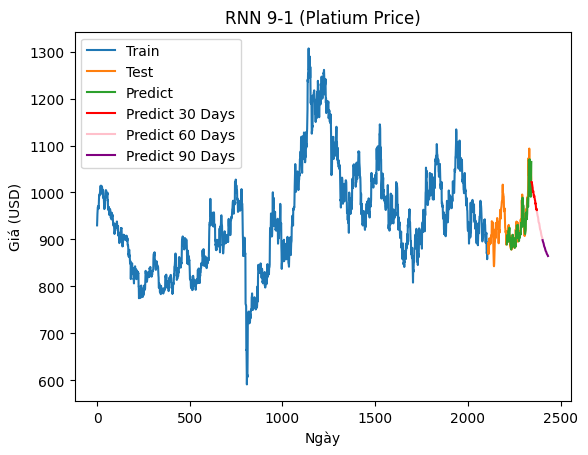

In [ ]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))

# Vẽ dữ liệu dự đoán 30 ngày tiếp theo
future_predict_index = pd.RangeIndex(start=train_size + test_size, stop=train_size + test_size + 30, step=1)
plt.plot(future_predict_index, scaler.inverse_transform(lst_output), color='red')

# Vẽ dữ liệu dự đoán 60 ngày tiếp theo
future_predict_index_60 = pd.RangeIndex(start=train_size + test_size + 30, stop=train_size + test_size + 60, step=1)
plt.plot(future_predict_index_60, scaler.inverse_transform(lst_output_60), color='pink')

# Vẽ dữ liệu dự đoán 90 ngày tiếp theo
future_predict_index_90 = pd.RangeIndex(start=train_size + test_size + 60, stop=train_size + test_size + 90, step=1)
plt.plot(future_predict_index_90, scaler.inverse_transform(lst_output_90), color='purple')
plt.legend(['Train','Test','Predict', 'Predict 30 Days', 'Predict 60 Days', 'Predict 90 Days'])
plt.title('RNN 9-1 (Platium Price)')
plt.xlabel('Ngày')
plt.ylabel('Giá (USD)')
plt.show()